# Physics-based Sound Synthesis

## Motivation
![taxonomy_sound_synthesis](images/taxonomy_sound_synthesis.png)
There are four approaches for sound synthesis. Traditionally, 

### Karplus-Strong algorithm
Karplus-Strong algorithm is an abstract algorithmic sound synthesis method.
![karplus_strong](images/karplus_strong.png)
**It's a self-modifying wavetable.** Wavetable is interpreted as a delay line, where the waveform propagates. Dullness is reduced considerably. Timbre and decay time depend on sampling rate



#### Tuning problem

High notes are **out of tune**: 
- $f=f_{S} /(L+0.5)$, where the half-sample delay is caused by averaging.
- Wavetable length $L$ is rounded to the nearest integer

![karplus_strong_tuning_problem](images/karplus_strong_tuning_problem.png)



## Introduction of Sound Synthesis by Physical Modeling
- Simulate the sound production mechanism
    - In speech synthesis and coding, this is an old tradition
- High-quality synthesis of string and wind instruments
- **More sophisticated signal processing than earlier**
    - Compared to subtractive synthesis, sampling & wavetable synthesis, FM synthesis
    - Combines linear & nonlinear methods, filtering, sampling
    - Considered computationally expensive

## Calssification of methods

1. Source-filter modeling
    - Physically informed subtractive synthesis
    - It's like an emulation of animal speech: the source signal is processed by a filter, e.g. a formant filter, and the resulting signal has a resonating structure such as a vocal tract or soundbox of an instrument. 
2. Finite Difference Modeling
    - Discretized wave equation (difference equation)
3. Mass-Spring Networks
    - "CORDIS-ANIMA" by ACROE (Grenoble, France)
4. Modal Synthesis
    - "Modalys" software by IRCAM; formerly "Mosaic"
    - The functional transform method by Trautmann and Rabenstein
5. Wave Digital Filters
    - Method to convert models of continuous-time systems into digital filters
6. Digital Waveguide Synthesis
    - Physical modeling using digital filters and delays; Main topic of this lecture

## Digital waveguide modeling

### Tuning with Fractional delay filter
Fine-tunes the delay-line length so that the pitch is right

### Tuning with Allpass filter
First-order allpass filter usually. Transient problems in time-varying cases.
- Phase delay of the first-order allpass filter at low frequencies(dc): $D=\left(1-a_{1}\right) /\left(1+a_{1}\right)$
- Phase delay: $-\phi(\omega) / \omega$
    - Phase response divided by angular frequency
- Solve $a_1$ for desired delay $D$: $a_{1}=\frac{1-D}{1+D}$

![tuning_all_pass](images/tuning_all_pass.png)

### Tuning with Lagrange interpolation
Order 3 or 4 is sufficient at 44.1 kHz. Linear interpolation(1st-order Lagrange) is not good enough because high frequencies will be damped.

Example: 3rd-order Lagrange FD filter ($N=3$), which is a four-tap FIR filter:
![tuning_with_lagrange_interpolation](images/tuning_with_lagrange_interpolation.png)

Coefficient formulas for 3rd-order Lagrange FD filter ($1 < D<2$):
$$
\begin{align}
    h(0) &=-\frac{1}{6}(D-1)(D-2)(D-3) \\
    h(1) &=\frac{1}{2} D(D-2)(D-3) \\
    h(2) &=-\frac{1}{2} D(D-1)(D-3) \\
    h(3) &=\frac{1}{6} D(D-1)(D-2)
\end{align}
$$

#### Loop filter
- Loop filter $H_l(z)$ controls the decay rate of harmonics
- One choice is a **one-pole filter**("leaky integrator"): $H_{l}(z)=g \frac{1+a_{1}}{1+a_{1} z^{-1}}$

    - Parameter $g$ determines overall decay rate ($0 < g < 1$)
    - Parameter $a_1$ determines frequency-dependent decay ($-1 < a_1 < 0$)

## Modeling of stringed musical instruments
Stringed instruments include both string and keyboard instruments such as guitar, harpsichord, piano, Clavinet and etc.

--------------------------

## Seyoung's Implementation of Karplus-Strong Algorithm
Karplus-Strong algorithm, invented in 1983, is a sound synthesis algorithm which is computationally cheap, but generates rich and natural sounds. It was motivated by the fact that such synthesis systems have been financially inaccessible to many musicians and hobbyists. It lacks the versatility of FM synthesis or additive synthesis, but it does generate rich timbres.

In [158]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio, display


### General wavetable generation

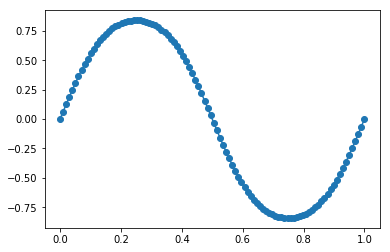

In [159]:
t = np.linspace(0,1, num=100)
wavetable = np.sin(np.sin(2 * np.pi * t))
plt.plot(t, wavetable, '-o')

In [17]:
from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage

duration = 2

pointer1 = 1
pointer2 = 2
points1 = []
points2 = []
fig, axes = plt.subplots(2, 1)
def make_frame(time):
    ax = axes[0]
    ax.clear()
    ax.plot(t, wavetable)
    ax.vlines(pointer1 * time / duration, -1, 1, color='red', label='slow pointer')
    ax.vlines(pointer2 * time / duration % 1, -1, 1, color='blue', label='fast pointer')
    for pointer, color, points in zip([pointer1, pointer2], ['red', 'blue'], [points1, points2]):
        arg = np.argmin(np.abs(t - (pointer * time / duration % 1)))
        ax.plot(t[arg], wavetable[arg], 'o', color=color)
        points.append(wavetable[arg])
    ax.set_xlim(0, 1)
    ax.legend(loc='lower left')
    
    ax2 = axes[1]
    ax2.clear()
    ax2.plot(points1, '-or')
    ax2.plot(points2, '-ob')
    ax2.set_xlim(0, 41)
    ax2.set_ylim(-1, 1)
    return mplfig_to_npimage(fig)

animation = VideoClip(make_frame, duration=duration)
plt.close(fig)
animation.ipython_display(fps=20, loop=True, autoplay=True)

 98%|█████████▊| 40/41 [00:03<00:00, 10.45it/s]


In [47]:
def synthesize(sampling_speed, wavetable, n_samples):
    samples = []
    current_sample = 0
    i = 1; j = 1
    while len(samples) < n_samples:
        current_sample += sampling_speed
        current_sample = current_sample % wavetable.size
        samples.append(wavetable[current_sample])
        n = len(samples)
        
        current_sample += 1
    
    return np.array(samples)

Text(0.5,0,'Sample Index')

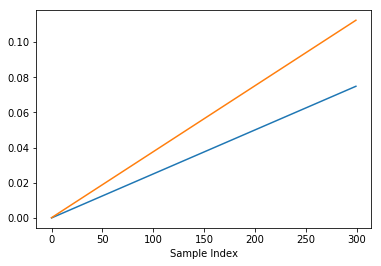

In [36]:
sample1 = synthesize(1, wavetable, 300)
sample2 = synthesize(2, wavetable, 300)
plt.plot(sample1)
plt.plot(sample2)
plt.xlabel('Sample Index')

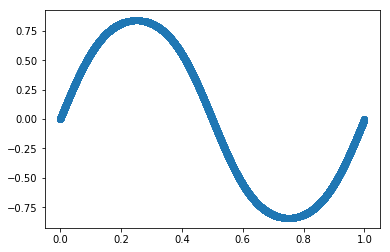

In [20]:
def get_timetable_and_wavetable(length, frequency):
    """
    Args:
        
    """
    t = np.linspace(0, length, num=frequency)
    return t, np.sin(np.sin(2 * np.pi * t))

fs = 8000
t, wavetable = get_timetable_and_wavetable(1, fs)
plt.plot(t, wavetable, '-o')

In [48]:
sample1 = synthesize(220, wavetable, 2 * fs)
sample2 = synthesize(440, wavetable, 2 * fs)

Audio(sample1, rate=fs)

In [49]:
Audio(sample2, rate=fs)

Triangle signal

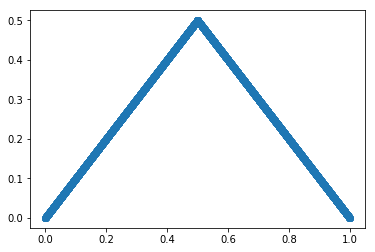

In [50]:
wavetable = t * (t < 0.5) + (-(t-1)) * (t >= 0.5)

plt.plot(t, wavetable, '-o')

In [51]:
sample1 = synthesize(220, wavetable, 2 * fs)
sample2 = synthesize(440, wavetable, 2 * fs)

Audio(sample1, rate=fs)

In [52]:
Audio(sample2, rate=fs)

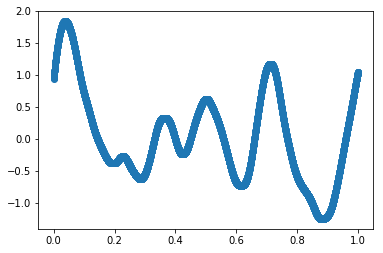

In [60]:
def make_sine_wavetable(n_samples, amps, phases, freqs):
    """Make a wavetable from a sum of sines"""
    t = np.linspace(0,1, num=n_samples)
    wavetable = np.zeros_like(t)
    for amp, phase, freq in zip(amps, phases, freqs):
        wavetable += amp * np.sin(np.sin(2 * np.pi * freq * t + phase)) \
                + amp / 2 * np.sin(np.sin(2 * np.pi * 2 * freq * t + phase))
        
    return wavetable

wavetable = make_sine_wavetable(
    t.size, 
    [0.1, 0.5, 0.8, 0.3], 
    [0, 0.3, 0.4, 0.7],
    [1, 2.1, 3, 4.3])

plt.plot(t, wavetable, '-o')

In [61]:
sample1 = synthesize(220, wavetable, 2 * fs)
sample2 = synthesize(440, wavetable, 2 * fs)

Audio(sample1, rate=fs)

In [62]:
Audio(sample2, rate=fs)

### Wavetable generation using Karplus-Strong algorithm

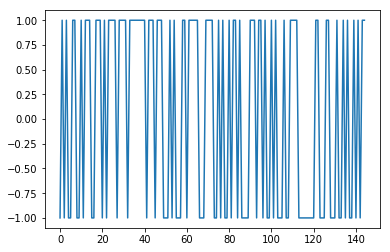

In [86]:
def karplus_strong(wavetable, n_samples):
    """Synthesize a new waveform from an existing 
    wavetable; modifies last sample by averaging
    
    """
    samples = []
    current_sample = 0
    previous_value = 0
    
    while len(samples) < n_samples:
        wavetable[current_sample] = 0.5 * (
            wavetable[current_sample] + previous_value
        )
        samples.append(wavetable[current_sample])
        previous_value = samples[-1]
        current_sample += 1
        current_sample = current_sample % wavetable.size
    
    return np.array(samples)



fs = 8000
wavetable_size = fs // 55
wavetable_source = (2 * np.random.randint(0,2,wavetable_size) - 1).astype(np.float32)
plt.plot(wavetable_source)

In [87]:
sample1 = karplus_strong(wavetable_source, 2 * fs)
Audio(sample1, rate=fs)

(0, 1000)

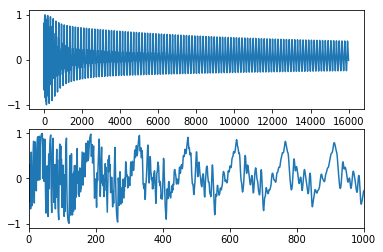

In [88]:
plt.subplot(211)
plt.plot(sample1)
plt.subplot(212)
plt.plot(sample1)
plt.xlim(0, 1000)

In [89]:
wavetable_size = fs // 110
wavetable_source = (2 * np.random.randint(0,2,wavetable_size) - 1).astype(np.float32)
sample2 = karplus_strong(wavetable_source, 2 * fs)
Audio(sample2, rate=fs)

(0, 1000)

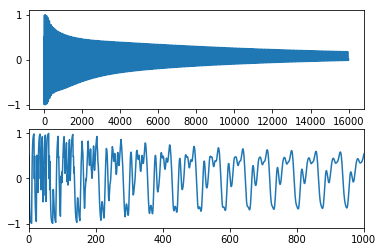

In [90]:
plt.subplot(211)
plt.plot(sample2)
plt.subplot(212)
plt.plot(sample2)
plt.xlim(0, 1000)

### Make a chromatic scale starting from A1, 55 Hz

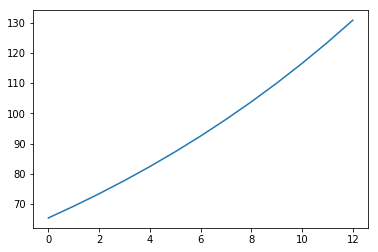

In [104]:
freqs = np.logspace(0,1, num=13, base=2) * 65.406
plt.plot(freqs)

In [101]:
for freq in freqs:
    wavetable_size = fs // int(freq)
    wavetable_source = (2 * np.random.randint(0,2,wavetable_size) - 1).astype(np.float32)
    sample = karplus_strong(wavetable_source, 2 * fs)
    display(Audio(sample, rate=fs))
    print(freq)

65.406


68.98802999835858


72.76623372556682


76.7513548470626


80.95472541668684


85.38829810040781


90.0646801648124


94.99716932701355


100.19979156791672


105.6873410163703


111.4754220176147


117.58049350565524


124.01991580573572


130.812


Text(0.5,1,'full waveforms of samples')

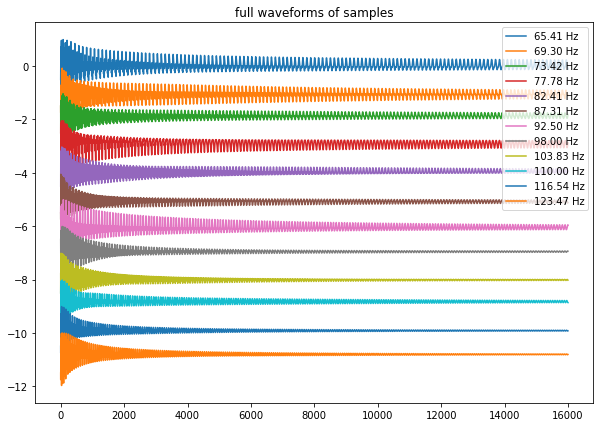

In [105]:
waveforms = []
for ind, freq in enumerate(freqs):
    wavetable_size = fs // int(freq)
    wavetable_source = (2 * np.random.randint(0,2,wavetable_size) - 1).astype(np.float32)
    sample = karplus_strong(wavetable_source, 2 * fs)
    waveforms.append(sample)
    
plt.figure(figsize=(10,7))

for ind, (waveform, freq) in enumerate(zip(waveforms, freqs[:-1])):
    plt.plot(waveform - ind, label=f'{freq:.2f} Hz')
plt.legend(loc='upper right')
plt.title('full waveforms of samples')

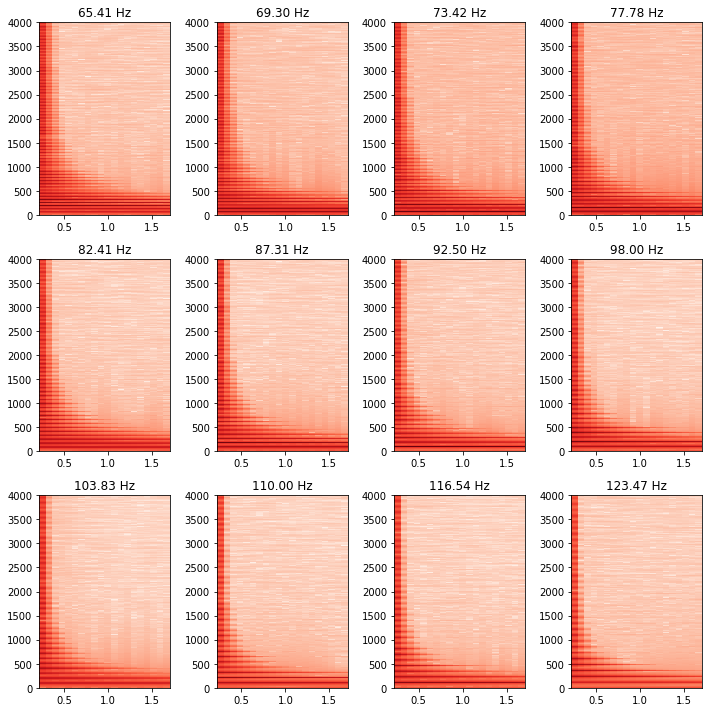

In [118]:
plt.figure(figsize=(10,10))
for ind, (waveform, freq) in enumerate(zip(waveforms, freqs[:-1])):
    plt.subplot(3,4,ind+1)
    plt.specgram(waveform, Fs=fs, NFFT=4096, noverlap=3500, cmap="Reds")
    plt.title(f'{freq:.2f} Hz')
plt.tight_layout()

In [147]:
r = np.random.binomial(1, 0.3)
sign = float(r == 1) * 2 - 1
sign

-1.0

In [149]:
class GuitarString:
    def __init__(self, pitch, starting_sample, sampling_freq, stretch_factor):
        """Inits the guitar string."""
        self.pitch = pitch
        self.starting_sample = starting_sample
        self.sampling_freq = sampling_freq
        self.stretch_factor = stretch_factor
        self.init_wavetable()
        self.current_sample = 0
        self.previous_value = 0
        
    def init_wavetable(self):
        """Generates a new wavetable for the string."""
        wavetable_size = self.sampling_freq // int(self.pitch)
        self.wavetable = (2 * np.random.randint(0, 2, wavetable_size) - 1).astype(np.float)
        
    def get_sample(self):
        """Returns next sample from string."""
        if self.current_sample >= self.starting_sample:
            current_sample_mod = self.current_sample % self.wavetable.size
            r = np.random.binomial(1, 1 - 1/self.stretch_factor)
            if r == 0:
                self.wavetable[current_sample_mod] =  0.5 * (self.wavetable[current_sample_mod] + self.previous_value)
            sample = self.wavetable[current_sample_mod]
            self.previous_value = sample
            self.current_sample += 1
        else:
            self.current_sample += 1
            sample = 0
        return sample
    
freqs = [98, 123, 147, 196, 294, 392, 392, 294, 196, 147, 123, 98]
unit_delay = fs//3
delays = [unit_delay * _ for _ in range(len(freqs))]
stretch_factors = [2 * f/98 for f in freqs]

strings = []
for freq, delay, stretch_factor in zip(freqs, delays, stretch_factors):
    string = GuitarString(freq, delay, fs, stretch_factor)
    strings.append(string)

## Conclusions

- Several methods available for physics-based sound synthesis
    - Source-filter, modal, mass-spring, FDTD, wave digital and digital waveguide models
- Digital waveguide synthesis used to be the most popular method 
- Modal synthesis and FDTD methods have become more attractive thanks to faster computers

## References

- http://lab.andre-michelle.com/karplus-strong-guitar